# **Clasificación de texto básico**

Se explica cómo hacer clasificación de texto usando archivos guardados en el disco. Primero se entrena un modelo binario para identificar si una opinión es positiva o negativa con el dataset de IMDB. Luego se propone un ejercicio para crear un modelo que clasifique varias categorías de preguntas de programación de Stack Overflow.



1) **Importación de librerías**

In [38]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


**Descripción**

Este código solo importa las librerías que se van a usar.

Sirven para:
* Hacer gráficas (matplotlib).
* Manejar archivos y texto (os, re, shutil, string).
* Usar TensorFlow para crear el modelo de clasificación de texto.

**Ver la versión de TensorFlow**

In [39]:
print(tf.__version__)

2.19.0


* Muestra qué versión de TensorFlow estás usando.

2) **Descargar el conjunto de datos IMDB**

In [40]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb_v1')

* Este código descarga el dataset IMDB desde internet y lo descomprime automáticamente.

3) **Ver carpetas del dataset**

In [41]:
os.listdir(dataset_dir)

['aclImdb']

* Muestra las carpetas de train y test.

4) **Acceder a la carpeta de entrenamiento del dataset**

In [42]:
train_dir = os.path.join(dataset_dir, 'aclImdb', 'train')
test_dir = os.path.join(dataset_dir, 'aclImdb', 'test')
os.listdir(train_dir)

['unsupBow.feat',
 'unsup',
 'urls_pos.txt',
 'urls_neg.txt',
 'pos',
 'urls_unsup.txt',
 'labeledBow.feat',
 'neg']

Este código crea la ruta que lleva a la carpeta train del dataset IMDB y muestra lo que contiene.

5) **Abrir y mostrar un ejemplo de reseña positiva**

In [43]:
sample_file = os.path.join(train_dir, 'pos', '1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


* Este código toma un archivo de ejemplo dentro de la carpeta pos (reseñas positivas), lo abre y muestra su contenido en pantalla.


# **Cargue el conjunto de datos**

Se cargan los datos desde el disco y se preparan para entrenar el modelo usando text_dataset_from_directory, que organiza los textos según las carpetas donde están guardados.

1) **Eliminación de carpeta no necesaria**

In [44]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

* Este código borra una carpeta que no se usará en el entrenamiento del modelo.

2) **Carga del dataset de entrenamiento**

In [45]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


* Este código crea el conjunto de datos de entrenamiento a partir de una carpeta que contiene textos clasificados.

3) **Vista previa de algunas reseñas del dataset**

In [46]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Este código muestra algunos ejemplos del dataset para verificar que las reseñas y sus etiquetas se cargaron correctamente.

* raw_train_ds.take(1) → toma solo un lote del dataset.

* El primer for recorre ese lote.

* El segundo for imprime las primeras 3 reseñas y sus etiquetas (0 = negativa, 1 = positiva).

4) **Mostrar el significado de cada etiqueta**

In [47]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


* Este código imprime a qué clase pertenece cada número de etiqueta del dataset.

5) **Carga del dataset de validación**

In [48]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Este código crea el conjunto de datos que se usará para validar el modelo mientras entrena.

* Usa la misma carpeta aclImdb/train.

* validation_split=0.2 → toma el 20% de los datos para validación.

* subset='validation' → indica que esta parte es la validación, no el entrenamiento.

* batch_size y seed se mantienen igual para que la división sea consistente.

6) **Carga del dataset de prueba**

In [49]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


* Este código carga el conjunto de datos que se usará para probar el modelo al final, después del entrenamiento.

# **Preparar el conjunto de datos para el entrenamiento**

Se preparan los datos para entrenar el modelo usando la capa TextVectorization, que permite estandarizar, tokenizar y vectorizar el texto.
Además, como las reseñas tienen etiquetas HTML, se crea una función personalizada para eliminarlas antes del entrenamiento.

**¿Para qué sirve?**

Para limpiar el texto, convertirlo en palabras y transformarlo en números que la red neuronal pueda entender.

1) **Función de limpieza del texto (preprocesamiento)**

In [50]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Esta función limpia cada texto antes de enviarlo al modelo.

**Paso por paso:**
 1. Convierte todo a minúsculas
tf.strings.lower() hace que el texto sea uniforme.

2. Quita las etiquetas HTML como <br />
Las reemplaza por espacios porque no aportan significado.

3. Elimina signos de puntuación
Usa una expresión regular para borrar comas, puntos, signos, etc.

2) **Creación de la capa de vectorización de texto**

In [51]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Este código crea una capa que transforma el texto en números para que el modelo pueda entenderlo.

**Parámetros importantes:**

* standardize=custom_standardization
Usa la función que limpia el texto antes de procesarlo.

* max_tokens=10000
Solo considera las 10,000 palabras más comunes del vocabulario.

* output_mode='int'
Convierte cada palabra en un número entero.

* output_sequence_length=250
Todas las reseñas se convierten en secuencias de 250 números (si son cortas se rellenan, si son largas se recortan).

3) **Adaptación de la capa de vectorización**

In [52]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Este código crea un dataset que contiene solo el texto (sin etiquetas) y luego usa esos textos para que la capa TextVectorization aprenda el vocabulario.

* train_text = raw_train_ds.map(lambda x, y: x) → extrae solo las reseñas.

* vectorize_layer.adapt(train_text) → la capa aprende qué palabras existen y cómo convertirlas en números.

4) **Función para vectorizar el texto y mantener su etiqueta**

In [53]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

Esta función transforma cada texto en una secuencia de números usando la capa de vectorización y mantiene su etiqueta correspondiente.

**Qué hace cada parte:**

* tf.expand_dims(text, -1)
Agrega una dimensión extra para que el texto tenga el formato correcto antes de ser procesado.

* vectorize_layer(text)
Convierte el texto en una secuencia de números según el vocabulario aprendido.

* return vectorize_layer(text), label
Devuelve el texto vectorizado junto con su etiqueta original.

5) **Vista previa de una reseña vectorizada**

In [54]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

Este código toma una reseña del dataset y muestra el texto original, su etiqueta y su versión convertida en números.

**Qué hace cada parte:**

* Obtiene un lote del dataset.

* Toma la primera reseña y su etiqueta.

* Imprime la reseña original.

* Imprime su etiqueta en texto.

* Muestra la reseña ya vectorizada.

6) **Visualización del vocabulario aprendido**

In [55]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


Este código muestra palabras específicas del vocabulario y el tamaño total del mismo.

**Qué hace cada parte:**

* vectorize_layer.get_vocabulary()[1287]
Muestra la palabra asignada al índice 1287.

* vectorize_layer.get_vocabulary()[313]
Muestra la palabra en la posición 313.

* len(vectorize_layer.get_vocabulary())
Indica cuántas palabras tiene el vocabulario.

7) **Creación de los datasets vectorizados**

In [56]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Este código convierte todos los textos de entrenamiento, validación y prueba en secuencias numéricas usando la función vectorize_text.

**Qué hace cada parte:**

* raw_train_ds.map(vectorize_text)
Vectoriza todas las reseñas del dataset de entrenamiento.

* raw_val_ds.map(vectorize_text)
Vectoriza las reseñas del dataset de validación.

* raw_test_ds.map(vectorize_text)
Vectoriza las reseñas del dataset de prueba.

8) **Optimización de los datasets para acelerar el entrenamiento**

In [57]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Este código mejora la velocidad del entrenamiento usando cache y prefetch, para que el modelo siempre tenga datos listos.

# **Crear el modelo**

Es hora de crear tu red neuronal:

1) **Definición del tamaño del embedding**

In [58]:
embedding_dim = 16

Define la dimensión del embedding, que es la forma compacta en la que el modelo entiende las palabras.

2) **Creación del modelo de clasificación de texto**

In [59]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Este código construye un modelo simple para clasificar reseñas como positivas o negativas.

**Capas del modelo:**

* Embedding(max_features + 1, embedding_dim)
Convierte cada palabra en un vector numérico.

* Dropout(0.2)
Apaga aleatoriamente neuronas para evitar sobreajuste.

* GlobalAveragePooling1D()
Resume toda la secuencia en un solo vector promedio.

* Dropout(0.2)
Otra capa para reducir sobreajuste.

* Dense(1)
Capa final que da la predicción (positivo o negativo).

3) **Compilación del modelo**

In [60]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

Este código configura cómo aprenderá y evaluará el modelo durante el entrenamiento.

# **Entrenamiento del modelo**

In [61]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - binary_accuracy: 0.5865 - loss: 0.6817 - val_binary_accuracy: 0.7252 - val_loss: 0.6154
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.7588 - loss: 0.5820 - val_binary_accuracy: 0.8120 - val_loss: 0.4999
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - binary_accuracy: 0.8227 - loss: 0.4684 - val_binary_accuracy: 0.8324 - val_loss: 0.4280
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8500 - loss: 0.3944 - val_binary_accuracy: 0.8354 - val_loss: 0.3894
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8677 - loss: 0.3503 - val_binary_accuracy: 0.8472 - val_loss: 0.3614
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - binary_accuracy: 0.8779 - loss: 0.3177 - val_binary_accuracy: 0.8552 - val_loss: 0.3421
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - binary_accuracy: 0.8893 - loss: 0.2911 - val_binary_accuracy: 0.8564 - val_loss: 0.3311
Epoch 

Este código entrena el modelo usando los datos vectorizados de entrenamiento y validación.

**Qué hace cada parte:**

* epochs = 10
El modelo entrenará durante 10 pasadas completas por el dataset.

* model.fit(train_ds, validation_data=val_ds, epochs=epochs)
Entrena el modelo con train_ds y evalúa su rendimiento en val_ds en cada época.

1) **Evaluación del modelo con el dataset de prueba**

In [62]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.8586 - loss: 0.3294
Loss:  0.3301376700401306
Accuracy:  0.8572800159454346


Este código mide qué tan bien funciona el modelo con datos que nunca vio durante el entrenamiento.

Qué hace cada parte:

* model.evaluate(test_ds)
Calcula la pérdida y la exactitud usando el dataset de prueba.

* print("Loss:", loss)
Muestra la pérdida final del modelo.

* print("Accuracy:", accuracy)
Muestra la precisión final del modelo.

2) **Historial del entrenamiento**

In [63]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

Este código accede a las métricas registradas durante el entrenamiento del modelo.

**Qué hace cada parte:**

* history.history
Contiene un diccionario con todos los valores de pérdida y precisión por época.

* history_dict.keys()
Muestra las métricas disponibles, como loss, binary_accuracy, val_loss y val_binary_accuracy.

# **Gráfico de pérdida durante el entrenamiento**

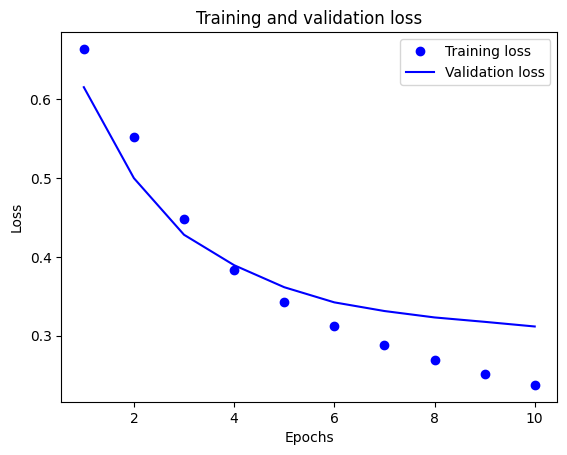

In [64]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Este código muestra cómo cambió la pérdida del modelo en el entrenamiento y la validación a lo largo de las épocas.

**Qué hace cada parte:**

* acc = history_dict['binary_accuracy'] y similares
Extrae las métricas de pérdida y precisión del historial.

* epochs = range(1, len(acc) + 1)
Define el eje X con el número de épocas.
* plt.plot(...)
Dibuja las curvas de pérdida para entrenamiento y validación.
* plt.show()
Muestra el gráfico.

# **Gráfico de precisión durante el entrenamiento**

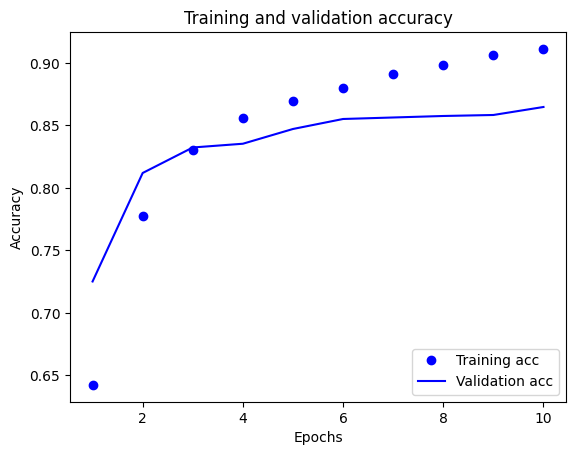

In [65]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

Este código muestra cómo cambió la precisión del modelo en entrenamiento y validación a lo largo de las épocas.

**Qué hace cada parte:**

* plt.plot(epochs, acc, 'bo', label='Training acc')
Dibuja la precisión del entrenamiento con puntos azules.

* plt.plot(epochs, val_acc, 'b', label='Validation acc')
Dibuja la precisión de validación con línea azul.

* plt.title, plt.xlabel, plt.ylabel, plt.legend
Configura título, etiquetas y leyenda del gráfico.

* plt.show()
Muestra el gráfico final.

# **Preparación del modelo para exportación y prueba con texto crudo**

In [66]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(raw_test_ds, return_dict=True)
print(metrics)

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5040 - loss: 0.5860
{'accuracy': 0.5000399947166443, 'loss': 0.5882737636566162}


Este código combina la capa de vectorización y el modelo entrenado en un solo modelo listo para usar con texto sin procesar.

**Predicción con ejemplos de texto**

In [67]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


array([[0.5855833 ],
       [0.55002755],
       [0.5361248 ]], dtype=float32)

Este código utiliza el modelo exportado para predecir si reseñas de películas son positivas o negativas.

**Qué hace cada parte:**

* examples = [...]
Lista de reseñas de ejemplo en texto crudo.

* export_model.predict(examples)
Devuelve la probabilidad de que cada reseña sea positiva (valores cercanos a 1) o negativa (valores cercanos a 0).

# **Conclusión**

Este proyecto muestra cómo construir un modelo de clasificación de texto que puede determinar si una reseña de película es positiva o negativa.

**Resumen de pasos y utilidad:**

1. **Carga y preparación de datos:**
Se descargan las reseñas de películas de IMDB, se limpian y organizan en datasets de entrenamiento, validación y prueba.

2. **Vectorización del texto:**
Se convierte el texto en números que la red neuronal puede entender mediante la capa TextVectorization.

3. **Creación y entrenamiento del modelo:**
Se construye un modelo simple con embeddings, pooling y capas densas, que aprende a clasificar las reseñas.

4. **Evaluación y optimización:**
Se mide la pérdida y precisión del modelo, y se visualiza su rendimiento durante el entrenamiento para detectar posibles problemas como sobreajuste.

5. **Exportación y uso con texto crudo:**
Se combina el modelo con la capa de vectorización, permitiendo hacer predicciones directamente sobre nuevas reseñas sin procesarlas manualmente.

**Utilidad:**

Este flujo de trabajo permite automatizar la clasificación de texto, lo que es útil en análisis de sentimientos, filtrado de comentarios, moderación de contenido y cualquier aplicación que requiera entender el sentimiento o la intención de textos de manera automática.